# Ecotype Correlation Analysis

Analyze the relationship between **environment** (embedding distance), **phylogeny** (ANI distance), and **gene content** (Jaccard distance) across species.

## Key Questions
1. Does environmental similarity predict gene content similarity?
2. Does this relationship hold after controlling for phylogenetic distance?
3. Which species show the strongest environment-gene content correlation?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
import os
from glob import glob
from collections import defaultdict

# Paths
DATA_DIR = '../data'
FIG_DIR = '../figures'

# Embedding columns
EMBEDDING_COLS = [f'A{i:02d}' for i in range(64)]

## 1. Load Data

In [2]:
# Load target genomes and species stats
target_genomes = pd.read_csv(f'{DATA_DIR}/target_genomes_expanded.csv')
species_stats = pd.read_csv(f'{DATA_DIR}/species_selection_stats.csv')
diversity_stats = pd.read_csv(f'{DATA_DIR}/species_embedding_diversity.csv')

print(f"Target genomes: {len(target_genomes):,}")
print(f"Species: {len(species_stats)}")
print(f"Species with valid diversity: {diversity_stats['mean_cosine_dist'].notna().sum()}")

Target genomes: 13,381
Species: 224
Species with valid diversity: 195


In [3]:
# Load embeddings
embeddings = pd.read_csv(f'{DATA_DIR}/embeddings_expanded.csv')
print(f"Embeddings loaded: {len(embeddings):,}")

# Check for null embeddings
null_mask = embeddings[EMBEDDING_COLS].isnull().any(axis=1)
print(f"Genomes with null embeddings: {null_mask.sum()}")

Embeddings loaded: 13,381
Genomes with null embeddings: 312


In [4]:
# Load ANI data (chunked)
ani_files = sorted(glob(f'{DATA_DIR}/ani_expanded/ani_chunk_*.csv'))
print(f"ANI chunks: {len(ani_files)}")

ani_chunks = []
for f in ani_files:
    chunk = pd.read_csv(f)
    ani_chunks.append(chunk)
    
ani_df = pd.concat(ani_chunks, ignore_index=True)
print(f"Total ANI pairs: {len(ani_df):,}")

ANI chunks: 2


Total ANI pairs: 781,234


In [5]:
# Load gene clusters (chunked)
cluster_files = sorted(glob(f'{DATA_DIR}/gene_clusters_expanded/clusters_chunk_*.csv'))
print(f"Gene cluster chunks: {len(cluster_files)}")

cluster_chunks = []
for f in cluster_files:
    chunk = pd.read_csv(f)
    cluster_chunks.append(chunk)
    
clusters_df = pd.concat(cluster_chunks, ignore_index=True)
print(f"Total gene-cluster associations: {len(clusters_df):,}")

Gene cluster chunks: 11
Total gene-cluster associations: 254,032


## 1.5 Ecological Categorization

Categorize species by ecological role using keyword-based matching on genus/species names.

In [6]:
def categorize_species(species_name):
    """
    Categorize a species by ecological role based on genus/species name patterns.
    Returns one of: Pathogen-Human, Pathogen-Animal, Commensal-Gut, Commensal-Skin,
                    Aquatic-Marine, Aquatic-Freshwater, Soil, Plant-Associated, Unknown
    """
    name = species_name.lower()
    
    # Human pathogens (priority - check first)
    human_pathogens = [
        'salmonella', 'mycobacterium_tuberculosis', 'klebsiella_pneumoniae',
        'staphylococcus_aureus', 'pseudomonas_aeruginosa', 'acinetobacter_baumannii',
        'enterococcus', 'clostridioides', 'clostridium_difficile', 'neisseria_gonorrhoeae',
        'neisseria_meningitidis', 'helicobacter_pylori', 'campylobacter_jejuni',
        'campylobacter_coli', 'listeria_monocytogenes', 'legionella', 'bordetella',
        'corynebacterium_diphtheriae', 'haemophilus_influenzae', 'streptococcus_pneumoniae',
        'streptococcus_pyogenes', 'escherichia_coli', 'shigella', 'yersinia',
        'vibrio_cholerae', 'francisella', 'brucella', 'burkholderia_pseudomallei',
        'chlamydia_trachomatis', 'treponema_pallidum', 'borrelia', 'rickettsia'
    ]
    
    # Animal pathogens (veterinary)
    animal_pathogens = [
        'mannheimia', 'pasteurella', 'actinobacillus', 'histophilus',
        'mycoplasma_bovis', 'mycoplasma_gallisepticum', 'erysipelothrix',
        'dichelobacter', 'fusobacterium_necrophorum', 'trueperella'
    ]
    
    # Gut commensals
    gut_commensals = [
        'bacteroides', 'bifidobacterium', 'faecalibacterium', 'blautia',
        'prevotella', 'akkermansia', 'roseburia', 'eubacterium', 'coprococcus',
        'ruminococcus', 'dorea', 'lachnospira', 'megamonas', 'dialister',
        'parabacteroides', 'alistipes', 'barnesiella', 'odoribacter'
    ]
    
    # Skin/oral commensals
    skin_oral = [
        'cutibacterium', 'propionibacterium', 'corynebacterium', 'staphylococcus_epidermidis',
        'staphylococcus_hominis', 'streptococcus_mutans', 'streptococcus_salivarius',
        'actinomyces', 'rothia', 'veillonella', 'fusobacterium_nucleatum',
        'porphyromonas_gingivalis', 'aggregatibacter'
    ]
    
    # Marine bacteria
    marine = [
        'vibrio', 'alteromonas', 'prochlorococcus', 'synechococcus',
        'roseobacter', 'pseudoalteromonas', 'shewanella', 'marinobacter',
        'idiomarina', 'halomonas', 'photobacterium', 'aliivibrio',
        'oceanospirillum', 'colwellia', 'glaciecola', 'moritella',
        'sulfitobacter', 'ruegeria', 'oceanobacillus'
    ]
    
    # Freshwater bacteria
    freshwater = [
        'caulobacter', 'brevundimonas', 'sphingomonas', 'novosphingobium',
        'limnohabitans', 'polynucleobacter', 'methylobacterium'
    ]
    
    # Soil bacteria
    soil = [
        'streptomyces', 'bacillus', 'paenibacillus', 'lysinibacillus',
        'arthrobacter', 'micrococcus', 'nocardia', 'rhodococcus',
        'mycobacterium_smegmatis', 'gordonia', 'actinoplanes',
        'micromonospora', 'amycolatopsis', 'kitasatospora',
        'azotobacter', 'azospirillum', 'azoarcus', 'geobacter'
    ]
    
    # Plant-associated
    plant = [
        'xanthomonas', 'pseudomonas_syringae', 'erwinia', 'pectobacterium',
        'dickeya', 'agrobacterium', 'rhizobium', 'bradyrhizobium',
        'sinorhizobium', 'mesorhizobium', 'ensifer', 'frankia',
        'pantoea', 'clavibacter', 'ralstonia_solanacearum', 'xylella',
        'gluconobacter', 'gluconacetobacter'
    ]
    
    # Check patterns in order of specificity
    for pattern in human_pathogens:
        if pattern in name:
            return 'Pathogen-Human'
    
    for pattern in animal_pathogens:
        if pattern in name:
            return 'Pathogen-Animal'
    
    for pattern in gut_commensals:
        if pattern in name:
            return 'Commensal-Gut'
    
    for pattern in skin_oral:
        if pattern in name:
            return 'Commensal-Skin/Oral'
    
    for pattern in marine:
        if pattern in name:
            return 'Aquatic-Marine'
    
    for pattern in freshwater:
        if pattern in name:
            return 'Aquatic-Freshwater'
    
    for pattern in soil:
        if pattern in name:
            return 'Soil'
    
    for pattern in plant:
        if pattern in name:
            return 'Plant-Associated'
    
    return 'Unknown'


# Apply categorization to all species
species_list = diversity_stats[diversity_stats['mean_cosine_dist'].notna()]['species'].tolist()
categories = []

for sp in species_list:
    short_name = sp.split('__')[1].split('--')[0]
    cat = categorize_species(short_name)
    categories.append({
        'species': sp,
        'short_name': short_name,
        'category': cat
    })

category_df = pd.DataFrame(categories)

# Summary
print("=== Ecological Categories ===")
print(category_df['category'].value_counts())

# Save for manual review
category_df.to_csv(f'{DATA_DIR}/species_ecological_categories.csv', index=False)
print(f"\nSaved to {DATA_DIR}/species_ecological_categories.csv")

=== Ecological Categories ===
category
Unknown                112
Commensal-Gut           40
Pathogen-Human          15
Plant-Associated        14
Commensal-Skin/Oral      7
Aquatic-Marine           4
Soil                     2
Aquatic-Freshwater       1
Name: count, dtype: int64

Saved to ../data/species_ecological_categories.csv


## 2. Build Per-Species Distance Matrices

In [7]:
def compute_species_distances(species_id, target_genomes, embeddings, ani_df, clusters_df):
    """
    Compute pairwise distance matrices for a species:
    - Embedding (cosine distance)
    - ANI (100 - ANI) - optional, may be sparse
    - Gene content (Jaccard distance)
    
    Returns dict with genome_ids and distance matrices, or None if insufficient data.
    """
    # Get genomes for this species
    species_genomes = target_genomes[target_genomes['gtdb_species_clade_id'] == species_id]['genome_id'].tolist()
    n = len(species_genomes)
    
    if n < 10:
        return None
    
    genome_to_idx = {g: i for i, g in enumerate(species_genomes)}
    
    # --- Embedding distances ---
    species_emb = embeddings[embeddings['genome_id'].isin(species_genomes)].copy()
    
    # Filter to genomes with valid embeddings
    valid_emb_mask = ~species_emb[EMBEDDING_COLS].isnull().any(axis=1)
    species_emb = species_emb[valid_emb_mask]
    
    if len(species_emb) < 10:
        return None  # Not enough genomes with valid embeddings
    
    # Use only genomes with valid embeddings
    valid_genomes = species_emb['genome_id'].tolist()
    n = len(valid_genomes)
    genome_to_idx = {g: i for i, g in enumerate(valid_genomes)}
    
    # Align to genome order
    species_emb = species_emb.set_index('genome_id').loc[valid_genomes]
    emb_matrix = species_emb[EMBEDDING_COLS].values
    emb_dist = squareform(pdist(emb_matrix, metric='cosine'))
    
    # --- ANI distances ---
    species_ani = ani_df[
        (ani_df['genome1_id'].isin(valid_genomes)) & 
        (ani_df['genome2_id'].isin(valid_genomes))
    ]
    
    ani_dist = np.zeros((n, n))
    ani_coverage = 0
    for _, row in species_ani.iterrows():
        i = genome_to_idx.get(row['genome1_id'])
        j = genome_to_idx.get(row['genome2_id'])
        if i is not None and j is not None:
            d = 100 - row['ANI']
            ani_dist[i, j] = d
            ani_dist[j, i] = d
            ani_coverage += 1
    
    # Check ANI coverage - need at least 50% of pairs
    expected_pairs = n * (n - 1) // 2
    has_ani = ani_coverage >= expected_pairs * 0.5
    
    # --- Gene content (Jaccard) distances ---
    species_clusters = clusters_df[clusters_df['genome_id'].isin(valid_genomes)]
    
    # Build genome -> set of clusters
    genome_clusters = defaultdict(set)
    for _, row in species_clusters.iterrows():
        genome_clusters[row['genome_id']].add(row['gene_cluster_id'])
    
    # Check gene content coverage
    genomes_with_clusters = sum(1 for g in valid_genomes if len(genome_clusters[g]) > 0)
    if genomes_with_clusters < n * 0.5:
        return None  # Not enough genomes with gene cluster data
    
    jaccard_dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            g1, g2 = valid_genomes[i], valid_genomes[j]
            s1, s2 = genome_clusters[g1], genome_clusters[g2]
            if len(s1) == 0 or len(s2) == 0:
                jaccard_dist[i, j] = np.nan
            else:
                intersection = len(s1 & s2)
                union = len(s1 | s2)
                jaccard_dist[i, j] = 1 - (intersection / union)
            jaccard_dist[j, i] = jaccard_dist[i, j]
    
    return {
        'species_id': species_id,
        'genome_ids': valid_genomes,
        'n_genomes': n,
        'emb_dist': emb_dist,
        'ani_dist': ani_dist if has_ani else None,
        'has_ani': has_ani,
        'ani_coverage': ani_coverage,
        'expected_pairs': expected_pairs,
        'jaccard_dist': jaccard_dist
    }

In [8]:
# Filter to species with valid embedding diversity
valid_species = diversity_stats[diversity_stats['mean_cosine_dist'].notna()]['species'].tolist()
print(f"Species with valid embeddings: {len(valid_species)}")

# Further filter to species with reasonable diversity (>0.05)
# Very low diversity means all genomes from same environment - no variation to correlate
diverse_species = diversity_stats[
    (diversity_stats['mean_cosine_dist'].notna()) & 
    (diversity_stats['mean_cosine_dist'] > 0.05)
]['species'].tolist()
print(f"Species with embedding diversity > 0.05: {len(diverse_species)}")

Species with valid embeddings: 195
Species with embedding diversity > 0.05: 172


## 3. Compute Correlations for Each Species

In [9]:
def partial_correlation(x, y, z):
    """
    Compute partial correlation between x and y, controlling for z.
    Uses residuals from linear regression.
    """
    from numpy.linalg import lstsq
    
    # Residualize x on z
    z_design = np.column_stack([np.ones(len(z)), z])
    coef_x, _, _, _ = lstsq(z_design, x, rcond=None)
    x_resid = x - z_design @ coef_x
    
    # Residualize y on z
    coef_y, _, _, _ = lstsq(z_design, y, rcond=None)
    y_resid = y - z_design @ coef_y
    
    # Correlation of residuals
    r, p = pearsonr(x_resid, y_resid)
    return r, p

In [10]:
# Compute correlations for each species
results = []
species_without_ani = 0
species_without_data = 0

for i, species_id in enumerate(diverse_species):
    if i % 20 == 0:
        print(f"Processing {i+1}/{len(diverse_species)}...")
    
    data = compute_species_distances(species_id, target_genomes, embeddings, ani_df, clusters_df)
    
    if data is None:
        species_without_data += 1
        continue
    
    # Extract upper triangle (pairwise comparisons)
    n = data['n_genomes']
    triu_idx = np.triu_indices(n, k=1)
    
    emb_flat = data['emb_dist'][triu_idx]
    jaccard_flat = data['jaccard_dist'][triu_idx]
    
    # Remove NaN values from Jaccard
    valid_mask = ~np.isnan(jaccard_flat)
    emb_flat = emb_flat[valid_mask]
    jaccard_flat = jaccard_flat[valid_mask]
    
    # Skip if not enough valid pairs or zero variance
    if len(emb_flat) < 10 or np.std(emb_flat) == 0 or np.std(jaccard_flat) == 0:
        species_without_data += 1
        continue
    
    # Raw correlation: environment vs gene content
    r_emb_jaccard, p_emb_jaccard = pearsonr(emb_flat, jaccard_flat)
    
    short_name = species_id.split('__')[1].split('--')[0]
    
    result = {
        'species': species_id,
        'short_name': short_name,
        'n_genomes': n,
        'n_pairs': len(emb_flat),
        'r_emb_jaccard': r_emb_jaccard,
        'p_emb_jaccard': p_emb_jaccard,
        'has_ani': data['has_ani'],
        'ani_coverage': data['ani_coverage'],
        'expected_pairs': data['expected_pairs']
    }
    
    # Only compute phylogeny correlations if we have ANI data
    if data['has_ani']:
        ani_flat = data['ani_dist'][triu_idx][valid_mask]
        
        if np.std(ani_flat) > 0:
            r_ani_jaccard, p_ani_jaccard = pearsonr(ani_flat, jaccard_flat)
            r_emb_ani, p_emb_ani = pearsonr(emb_flat, ani_flat)
            
            # Partial correlations
            r_partial_emb, p_partial_emb = partial_correlation(emb_flat, jaccard_flat, ani_flat)
            r_partial_ani, p_partial_ani = partial_correlation(ani_flat, jaccard_flat, emb_flat)
            
            result.update({
                'r_ani_jaccard': r_ani_jaccard,
                'p_ani_jaccard': p_ani_jaccard,
                'r_emb_ani': r_emb_ani,
                'p_emb_ani': p_emb_ani,
                'r_partial_emb_jaccard': r_partial_emb,
                'p_partial_emb': p_partial_emb,
                'r_partial_ani_jaccard': r_partial_ani,
                'p_partial_ani': p_partial_ani
            })
    else:
        species_without_ani += 1
    
    results.append(result)

results_df = pd.DataFrame(results)
print(f"\nComputed correlations for {len(results_df)} species")
print(f"  - With ANI (partial correlations): {(results_df['has_ani'] == True).sum()}")
print(f"  - Without ANI (raw correlations only): {species_without_ani}")
print(f"  - Skipped (insufficient data): {species_without_data}")

Processing 1/172...


Processing 21/172...


Processing 41/172...


Processing 61/172...


Processing 81/172...


Processing 101/172...


Processing 121/172...


Processing 141/172...


Processing 161/172...



Computed correlations for 172 species
  - With ANI (partial correlations): 172
  - Without ANI (raw correlations only): 0
  - Skipped (insufficient data): 0


In [11]:
# Save results
results_df.to_csv(f'{DATA_DIR}/ecotype_correlation_results.csv', index=False)
print(f"Saved to {DATA_DIR}/ecotype_correlation_results.csv")

Saved to ../data/ecotype_correlation_results.csv


## 4. Analyze Results

In [12]:
# Summary statistics
print("=== Correlation Summary ===")
print(f"\nTotal species analyzed: {len(results_df)}")

# Check which columns exist and have data
has_ani_data = 'r_ani_jaccard' in results_df.columns and results_df['r_ani_jaccard'].notna().sum() > 0
has_partial = 'r_partial_emb_jaccard' in results_df.columns and results_df['r_partial_emb_jaccard'].notna().sum() > 0

print(f"Species with ANI data: {results_df['has_ani'].sum() if 'has_ani' in results_df.columns else 0}")

print(f"\nEnvironment vs Gene Content (r_emb_jaccard):")
print(results_df['r_emb_jaccard'].describe())

if has_ani_data:
    print(f"\nPhylogeny vs Gene Content (r_ani_jaccard):")
    print(results_df['r_ani_jaccard'].dropna().describe())
else:
    print("\n[No ANI data available - partial correlations not computed]")

if has_partial:
    print(f"\nPartial: Environment | Phylogeny (r_partial_emb_jaccard):")
    print(results_df['r_partial_emb_jaccard'].dropna().describe())

    print(f"\nPartial: Phylogeny | Environment (r_partial_ani_jaccard):")
    print(results_df['r_partial_ani_jaccard'].dropna().describe())

    # Compare the two partial correlations (only for species with both)
    valid_partial = results_df[results_df['r_partial_emb_jaccard'].notna() & results_df['r_partial_ani_jaccard'].notna()]
    print("\n=== Which Factor Dominates? ===")
    env_stronger = (valid_partial['r_partial_emb_jaccard'] > valid_partial['r_partial_ani_jaccard']).sum()
    phylo_stronger = (valid_partial['r_partial_ani_jaccard'] > valid_partial['r_partial_emb_jaccard']).sum()
    print(f"Species where Environment effect > Phylogeny effect: {env_stronger}")
    print(f"Species where Phylogeny effect > Environment effect: {phylo_stronger}")

=== Correlation Summary ===

Total species analyzed: 172
Species with ANI data: 172

Environment vs Gene Content (r_emb_jaccard):
count    172.000000
mean       0.004661
std        0.042711
min       -0.161085
25%       -0.013416
50%        0.006241
75%        0.027093
max        0.151593
Name: r_emb_jaccard, dtype: float64

Phylogeny vs Gene Content (r_ani_jaccard):
count    172.000000
mean       0.015706
std        0.045669
min       -0.156260
25%       -0.006811
50%        0.015156
75%        0.041069
max        0.197241
Name: r_ani_jaccard, dtype: float64

Partial: Environment | Phylogeny (r_partial_emb_jaccard):
count    172.000000
mean      -0.001955
std        0.044130
min       -0.158940
25%       -0.020100
50%        0.002549
75%        0.018167
max        0.134150
Name: r_partial_emb_jaccard, dtype: float64

Partial: Phylogeny | Environment (r_partial_ani_jaccard):
count    172.000000
mean       0.016498
std        0.046527
min       -0.149974
25%       -0.003117
50%        0

In [13]:
# Species with strongest environment-gene content correlation
# Show both raw and partial (if available)

print("\n=== Top Species: Strongest Environment-Gene Content Signal ===")

# Check if we have partial correlations
has_partial = 'r_partial_emb_jaccard' in results_df.columns and results_df['r_partial_emb_jaccard'].notna().sum() > 0

if has_partial:
    print("(Partial correlation, controlling for ANI)\n")
    partial_df = results_df[results_df['r_partial_emb_jaccard'].notna()]
    if len(partial_df) > 0:
        top_species = partial_df.nlargest(20, 'r_partial_emb_jaccard')[
            ['short_name', 'n_genomes', 'r_partial_emb_jaccard', 'p_partial_emb', 'r_ani_jaccard']
        ]
        print(top_species.to_string(index=False))
    else:
        print("No species with partial correlation data")
else:
    print("(Raw correlation - no ANI data for partial correlation)\n")
    top_species = results_df.nlargest(20, 'r_emb_jaccard')[
        ['short_name', 'n_genomes', 'r_emb_jaccard', 'p_emb_jaccard']
    ]
    print(top_species.to_string(index=False))


=== Top Species: Strongest Environment-Gene Content Signal ===
(Partial correlation, controlling for ANI)

                  short_name  n_genomes  r_partial_emb_jaccard  p_partial_emb  r_ani_jaccard
      Mycobacterium_kansasii         22               0.134150       0.041644      -0.063568
       Planktothrix_agardhii         20               0.133198       0.066941       0.118060
             ER4_sp900317525         22               0.126553       0.054766      -0.012822
Faecalibacterium_prausnitzii         35               0.099337       0.015351       0.060336
   Mesorhizobium_sp004020645         22               0.085654       0.194577      -0.071622
       Acinetobacter_towneri         38               0.078157       0.038289      -0.022644
        Cutibacterium_avidum         25               0.068457       0.237147      -0.100202
   Clavibacter_michiganensis         35               0.068147       0.096768       0.000307
       Acinetobacter_indicus         46               0

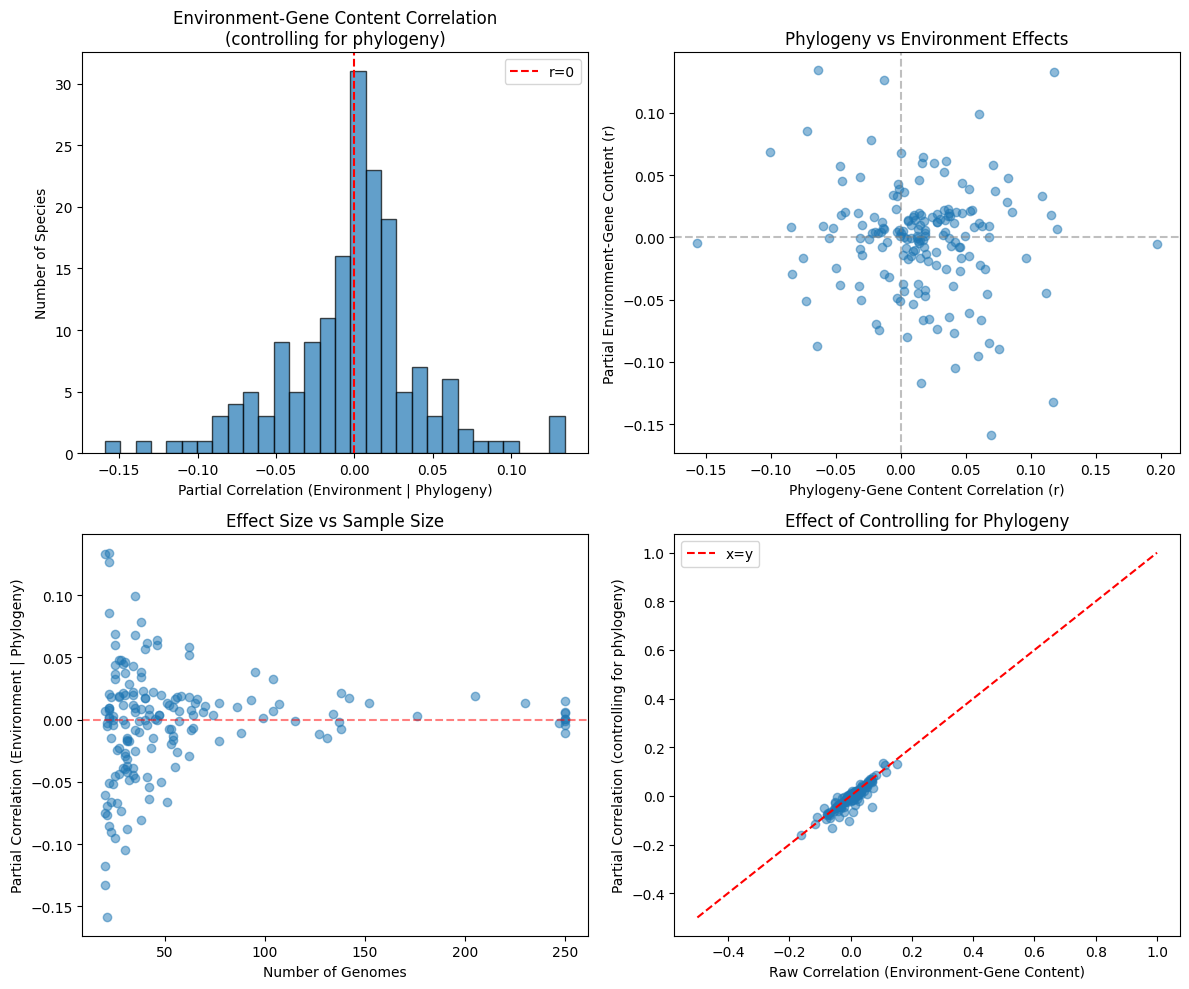


Figure saved to ../figures/ecotype_correlation_summary.png


In [14]:
# Visualize results
# Adapt based on whether we have partial correlation data

has_partial = 'r_partial_emb_jaccard' in results_df.columns and results_df['r_partial_emb_jaccard'].notna().sum() > 0
has_ani = 'r_ani_jaccard' in results_df.columns and results_df['r_ani_jaccard'].notna().sum() > 0

if has_partial:
    # Full 4-panel visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    partial_df = results_df[results_df['r_partial_emb_jaccard'].notna()]

    # 1. Distribution of partial correlations
    ax = axes[0, 0]
    ax.hist(partial_df['r_partial_emb_jaccard'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='r=0')
    ax.set_xlabel('Partial Correlation (Environment | Phylogeny)')
    ax.set_ylabel('Number of Species')
    ax.set_title('Environment-Gene Content Correlation\n(controlling for phylogeny)')
    ax.legend()

    # 2. Environment vs Phylogeny effect
    ax = axes[0, 1]
    ax.scatter(partial_df['r_ani_jaccard'], partial_df['r_partial_emb_jaccard'], alpha=0.5)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Phylogeny-Gene Content Correlation (r)')
    ax.set_ylabel('Partial Environment-Gene Content (r)')
    ax.set_title('Phylogeny vs Environment Effects')

    # 3. Sample size effect
    ax = axes[1, 0]
    ax.scatter(partial_df['n_genomes'], partial_df['r_partial_emb_jaccard'], alpha=0.5)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Genomes')
    ax.set_ylabel('Partial Correlation (Environment | Phylogeny)')
    ax.set_title('Effect Size vs Sample Size')

    # 4. Raw vs partial correlation
    ax = axes[1, 1]
    ax.scatter(partial_df['r_emb_jaccard'], partial_df['r_partial_emb_jaccard'], alpha=0.5)
    ax.plot([-0.5, 1], [-0.5, 1], 'r--', label='x=y')
    ax.set_xlabel('Raw Correlation (Environment-Gene Content)')
    ax.set_ylabel('Partial Correlation (controlling for phylogeny)')
    ax.set_title('Effect of Controlling for Phylogeny')
    ax.legend()

else:
    # Simplified 2-panel visualization (no partial correlations)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Distribution of raw correlations
    ax = axes[0]
    ax.hist(results_df['r_emb_jaccard'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='r=0')
    ax.set_xlabel('Correlation (Environment vs Gene Content)')
    ax.set_ylabel('Number of Species')
    ax.set_title('Environment-Gene Content Correlation\n(raw - no phylogeny control)')
    ax.legend()

    # 2. Sample size effect
    ax = axes[1]
    ax.scatter(results_df['n_genomes'], results_df['r_emb_jaccard'], alpha=0.5)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Genomes')
    ax.set_ylabel('Correlation (Environment vs Gene Content)')
    ax.set_title('Effect Size vs Sample Size')

plt.tight_layout()
plt.savefig(f'{FIG_DIR}/ecotype_correlation_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to {FIG_DIR}/ecotype_correlation_summary.png")

## 6. Compare by Ecological Category

Analyze whether environment vs phylogeny effects differ across ecological categories.

In [15]:
# Merge categories with correlation results
results_with_cat = results_df.merge(
    category_df[['species', 'category']], 
    on='species', 
    how='left'
)

# Fill any missing categories
results_with_cat['category'] = results_with_cat['category'].fillna('Unknown')

print("=== Species per Category (with valid correlations) ===")
print(results_with_cat['category'].value_counts())

=== Species per Category (with valid correlations) ===
category
Unknown                97
Commensal-Gut          36
Pathogen-Human         15
Plant-Associated       14
Commensal-Skin/Oral     6
Aquatic-Marine          2
Soil                    2
Name: count, dtype: int64


/var/folders/x7/5bdmf0vs4697cfj24t4kzl1c0000gq/T/ipykernel_45950/2549450348.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=cat_order, patch_artist=True)
/var/folders/x7/5bdmf0vs4697cfj24t4kzl1c0000gq/T/ipykernel_45950/2549450348.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=cat_order, patch_artist=True)


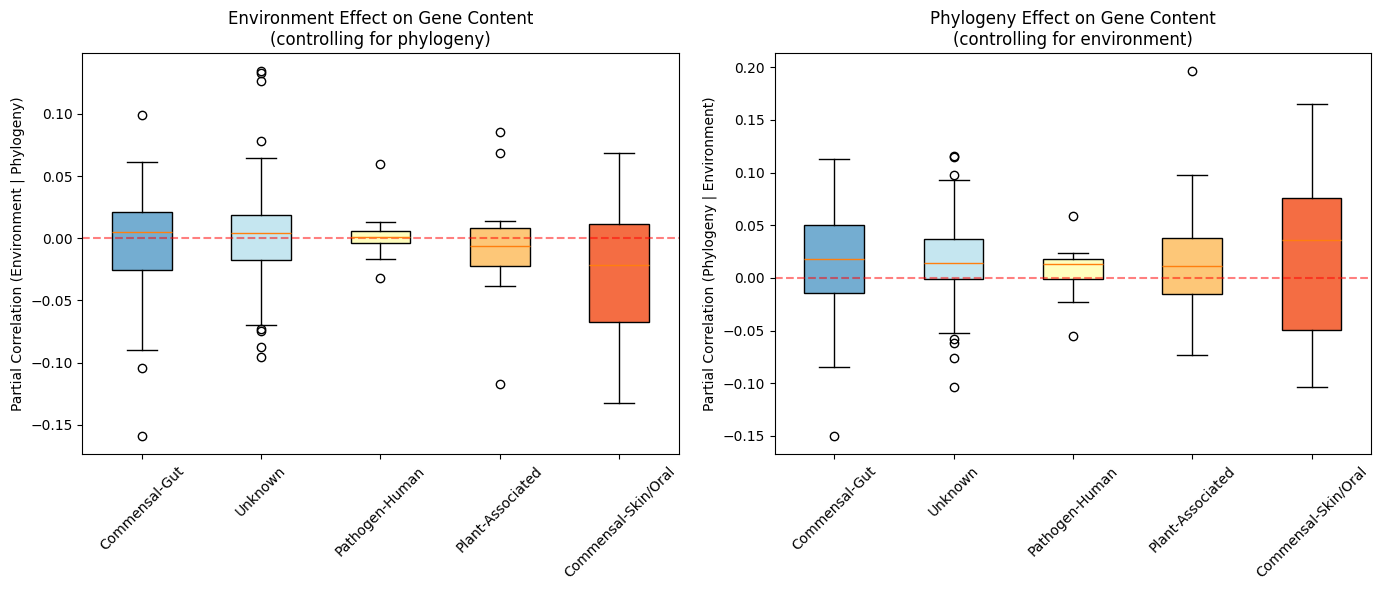


=== Kruskal-Wallis Test (differences across categories) ===
Environment effect: H=1.88, p=0.7570

Figure saved to ../figures/ecotype_by_category.png


In [16]:
# Box plots comparing correlations by category
from scipy.stats import kruskal

has_partial = 'r_partial_emb_jaccard' in results_with_cat.columns and results_with_cat['r_partial_emb_jaccard'].notna().sum() > 3

# Filter to categories with enough species
cat_counts = results_with_cat['category'].value_counts()
valid_cats = cat_counts[cat_counts >= 3].index.tolist()
plot_df = results_with_cat[results_with_cat['category'].isin(valid_cats)]

if len(plot_df) < 5:
    print("Not enough data for category comparison plots")
elif has_partial:
    # Use partial correlations if available
    partial_df = plot_df[plot_df['r_partial_emb_jaccard'].notna()]
    
    if len(partial_df) >= 5:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Order categories by median environment partial correlation
        cat_order = partial_df.groupby('category')['r_partial_emb_jaccard'].median().sort_values(ascending=False).index.tolist()

        # 1. Environment effect (controlling for phylogeny)
        ax = axes[0]
        box_data = [partial_df[partial_df['category'] == cat]['r_partial_emb_jaccard'].values for cat in cat_order]
        bp = ax.boxplot(box_data, labels=cat_order, patch_artist=True)
        ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        ax.set_ylabel('Partial Correlation (Environment | Phylogeny)')
        ax.set_title('Environment Effect on Gene Content\n(controlling for phylogeny)')
        ax.tick_params(axis='x', rotation=45)

        # Color by median value
        colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(cat_order)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # 2. Phylogeny effect (controlling for environment)
        ax = axes[1]
        box_data = [partial_df[partial_df['category'] == cat]['r_partial_ani_jaccard'].values for cat in cat_order]
        bp = ax.boxplot(box_data, labels=cat_order, patch_artist=True)
        ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        ax.set_ylabel('Partial Correlation (Phylogeny | Environment)')
        ax.set_title('Phylogeny Effect on Gene Content\n(controlling for environment)')
        ax.tick_params(axis='x', rotation=45)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        plt.tight_layout()
        plt.savefig(f'{FIG_DIR}/ecotype_by_category.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Kruskal-Wallis test for differences
        groups_env = [partial_df[partial_df['category'] == cat]['r_partial_emb_jaccard'].dropna().values for cat in valid_cats if len(partial_df[partial_df['category'] == cat]) >= 2]
        if len(groups_env) >= 2:
            stat_env, p_env = kruskal(*groups_env)
            print(f"\n=== Kruskal-Wallis Test (differences across categories) ===")
            print(f"Environment effect: H={stat_env:.2f}, p={p_env:.4f}")

        print(f"\nFigure saved to {FIG_DIR}/ecotype_by_category.png")
    else:
        print("Not enough species with partial correlation data for category comparison")
else:
    # Use raw correlations
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Order categories by median raw correlation
    cat_order = plot_df.groupby('category')['r_emb_jaccard'].median().sort_values(ascending=False).index.tolist()
    
    box_data = [plot_df[plot_df['category'] == cat]['r_emb_jaccard'].values for cat in cat_order]
    bp = ax.boxplot(box_data, labels=cat_order, patch_artist=True)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Correlation (Environment vs Gene Content)')
    ax.set_title('Environment-Gene Content Correlation by Category\n(raw - no phylogeny control)')
    ax.tick_params(axis='x', rotation=45)
    
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(cat_order)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.savefig(f'{FIG_DIR}/ecotype_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Kruskal-Wallis test
    groups = [plot_df[plot_df['category'] == cat]['r_emb_jaccard'].values for cat in valid_cats if len(plot_df[plot_df['category'] == cat]) >= 2]
    if len(groups) >= 2:
        stat, p = kruskal(*groups)
        print(f"\n=== Kruskal-Wallis Test (differences across categories) ===")
        print(f"Environment effect: H={stat:.2f}, p={p:.4f}")
    
    print(f"\nFigure saved to {FIG_DIR}/ecotype_by_category.png")

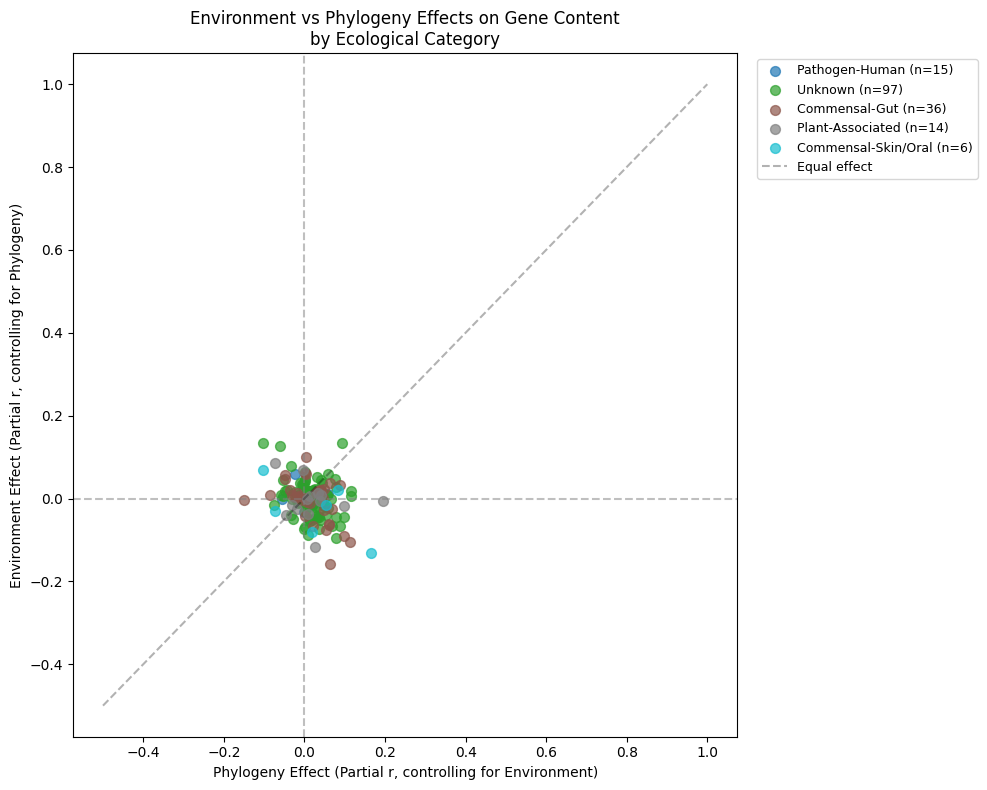

Figure saved to ../figures/ecotype_scatter_by_category.png


In [17]:
# Scatter plot: Correlation colored by category
has_partial = 'r_partial_emb_jaccard' in plot_df.columns and plot_df['r_partial_emb_jaccard'].notna().sum() > 3

if has_partial:
    # Scatter: Environment vs Phylogeny partial effects
    partial_df = plot_df[plot_df['r_partial_emb_jaccard'].notna()]
    
    if len(partial_df) >= 5:
        fig, ax = plt.subplots(figsize=(10, 8))

        categories_unique = partial_df['category'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(categories_unique)))
        color_map = dict(zip(categories_unique, colors))

        for cat in categories_unique:
            cat_data = partial_df[partial_df['category'] == cat]
            ax.scatter(
                cat_data['r_partial_ani_jaccard'], 
                cat_data['r_partial_emb_jaccard'],
                c=[color_map[cat]], 
                label=f"{cat} (n={len(cat_data)})",
                alpha=0.7,
                s=50
            )

        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
        ax.plot([-0.5, 1], [-0.5, 1], 'k--', alpha=0.3, label='Equal effect')

        ax.set_xlabel('Phylogeny Effect (Partial r, controlling for Environment)')
        ax.set_ylabel('Environment Effect (Partial r, controlling for Phylogeny)')
        ax.set_title('Environment vs Phylogeny Effects on Gene Content\nby Ecological Category')
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

        plt.tight_layout()
        plt.savefig(f'{FIG_DIR}/ecotype_scatter_by_category.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Figure saved to {FIG_DIR}/ecotype_scatter_by_category.png")
    else:
        print("Not enough species with partial correlation data for scatter plot")
else:
    # Scatter: Raw correlation vs sample size, colored by category
    fig, ax = plt.subplots(figsize=(10, 8))

    categories_unique = plot_df['category'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories_unique)))
    color_map = dict(zip(categories_unique, colors))

    for cat in categories_unique:
        cat_data = plot_df[plot_df['category'] == cat]
        ax.scatter(
            cat_data['n_genomes'], 
            cat_data['r_emb_jaccard'],
            c=[color_map[cat]], 
            label=f"{cat} (n={len(cat_data)})",
            alpha=0.7,
            s=50
        )

    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Genomes')
    ax.set_ylabel('Correlation (Environment vs Gene Content)')
    ax.set_title('Environment-Gene Content Correlation by Sample Size\nColored by Ecological Category')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'{FIG_DIR}/ecotype_scatter_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Figure saved to {FIG_DIR}/ecotype_scatter_by_category.png")

In [18]:
# Summary by category
print("=== Summary by Ecological Category ===\n")

has_partial = 'r_partial_emb_jaccard' in plot_df.columns and plot_df['r_partial_emb_jaccard'].notna().sum() > 3

if has_partial:
    partial_df = plot_df[plot_df['r_partial_emb_jaccard'].notna()]
    
    if len(partial_df) >= 3:
        summary = partial_df.groupby('category').agg({
            'n_genomes': 'sum',
            'r_partial_emb_jaccard': ['median', 'mean', 'std'],
            'r_partial_ani_jaccard': ['median', 'mean', 'std']
        }).round(3)

        summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
        summary = summary.rename(columns={
            'n_genomes_sum': 'total_genomes',
            'r_partial_emb_jaccard_median': 'env_median',
            'r_partial_emb_jaccard_mean': 'env_mean',
            'r_partial_emb_jaccard_std': 'env_std',
            'r_partial_ani_jaccard_median': 'phylo_median',
            'r_partial_ani_jaccard_mean': 'phylo_mean',
            'r_partial_ani_jaccard_std': 'phylo_std'
        })

        # Add species count
        summary['n_species'] = partial_df.groupby('category').size()

        # Determine dominant factor
        summary['dominant'] = summary.apply(
            lambda row: 'Environment' if row['env_median'] > row['phylo_median'] else 'Phylogeny', 
            axis=1
        )

        print(summary[['n_species', 'env_median', 'phylo_median', 'dominant']].sort_values('env_median', ascending=False))
    else:
        print("Not enough species with partial correlation data for category summary")
else:
    # Summary using raw correlations
    summary = plot_df.groupby('category').agg({
        'n_genomes': 'sum',
        'r_emb_jaccard': ['median', 'mean', 'std', 'count']
    }).round(3)

    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.rename(columns={
        'n_genomes_sum': 'total_genomes',
        'r_emb_jaccard_median': 'env_median',
        'r_emb_jaccard_mean': 'env_mean',
        'r_emb_jaccard_std': 'env_std',
        'r_emb_jaccard_count': 'n_species'
    })

    print("Note: Using raw correlations (no ANI data for partial correlations)\n")
    print(summary[['n_species', 'total_genomes', 'env_median', 'env_mean', 'env_std']].sort_values('env_median', ascending=False))

# Save final results with categories
results_with_cat.to_csv(f'{DATA_DIR}/ecotype_correlation_results_with_categories.csv', index=False)
print(f"\nSaved results with categories to {DATA_DIR}/ecotype_correlation_results_with_categories.csv")

=== Summary by Ecological Category ===

                     n_species  env_median  phylo_median   dominant
category                                                           
Commensal-Gut               36       0.005         0.018  Phylogeny
Unknown                     97       0.004         0.015  Phylogeny
Pathogen-Human              15       0.001         0.013  Phylogeny
Plant-Associated            14      -0.006         0.011  Phylogeny
Commensal-Skin/Oral          6      -0.022         0.036  Phylogeny

Saved results with categories to ../data/ecotype_correlation_results_with_categories.csv


## 5. Summary Statistics

In [19]:
# Significance summary
sig_threshold = 0.05

has_partial = 'r_partial_emb_jaccard' in results_df.columns and results_df['r_partial_emb_jaccard'].notna().sum() > 0

if has_partial:
    # Use partial correlations
    partial_df = results_df[results_df['p_partial_emb'].notna()]
    
    n_sig_positive = ((partial_df['r_partial_emb_jaccard'] > 0) & (partial_df['p_partial_emb'] < sig_threshold)).sum()
    n_sig_negative = ((partial_df['r_partial_emb_jaccard'] < 0) & (partial_df['p_partial_emb'] < sig_threshold)).sum()
    n_not_sig = (partial_df['p_partial_emb'] >= sig_threshold).sum()
    total = len(partial_df)

    print(f"=== Significance Summary - Partial Correlations (p < {sig_threshold}) ===")
    print(f"Species with ANI data: {total}")
    print(f"Significant positive effect: {n_sig_positive} ({100*n_sig_positive/total:.1f}%)" if total > 0 else "N/A")
    print(f"Significant negative effect: {n_sig_negative} ({100*n_sig_negative/total:.1f}%)" if total > 0 else "N/A")
    print(f"Not significant: {n_not_sig} ({100*n_not_sig/total:.1f}%)" if total > 0 else "N/A")

    if total > 0:
        median_partial = partial_df['r_partial_emb_jaccard'].median()
        print(f"\n=== Key Finding ===")
        print(f"Median partial correlation: {median_partial:.3f}")
        if median_partial > 0:
            print("Environment tends to predict gene content BEYOND phylogeny alone.")
        else:
            print("Environment does not add much beyond phylogeny for most species.")
else:
    # Use raw correlations
    n_sig_positive = ((results_df['r_emb_jaccard'] > 0) & (results_df['p_emb_jaccard'] < sig_threshold)).sum()
    n_sig_negative = ((results_df['r_emb_jaccard'] < 0) & (results_df['p_emb_jaccard'] < sig_threshold)).sum()
    n_not_sig = (results_df['p_emb_jaccard'] >= sig_threshold).sum()
    total = len(results_df)

    print(f"=== Significance Summary - Raw Correlations (p < {sig_threshold}) ===")
    print(f"(Note: No ANI data available for partial correlations)")
    print(f"\nTotal species analyzed: {total}")
    print(f"Significant positive effect: {n_sig_positive} ({100*n_sig_positive/total:.1f}%)" if total > 0 else "N/A")
    print(f"Significant negative effect: {n_sig_negative} ({100*n_sig_negative/total:.1f}%)" if total > 0 else "N/A")
    print(f"Not significant: {n_not_sig} ({100*n_not_sig/total:.1f}%)" if total > 0 else "N/A")

    if total > 0:
        median_raw = results_df['r_emb_jaccard'].median()
        print(f"\n=== Key Finding ===")
        print(f"Median raw correlation: {median_raw:.3f}")
        if median_raw > 0:
            print("Environment tends to predict gene content (but phylogeny effect not controlled).")
        else:
            print("Environment does not strongly predict gene content.")
        print("\nNote: Re-run ANI extraction on cluster to enable partial correlation analysis.")

=== Significance Summary - Partial Correlations (p < 0.05) ===
Species with ANI data: 172
Significant positive effect: 12 (7.0%)
Significant negative effect: 4 (2.3%)
Not significant: 156 (90.7%)

=== Key Finding ===
Median partial correlation: 0.003
Environment tends to predict gene content BEYOND phylogeny alone.
